In [1]:
import torch
from torch_geometric.data import Data
import networkx as nx
import pandas as pd

In [2]:
graph = nx.read_graphml('../Graphs/pearson_correlation_threshold_graph.graphml')

In [3]:
graph

In [4]:
for node_id, attributes in graph.nodes(data=True):
    print(f"Node {node_id}: {attributes}")

Node A: {'Name': 'Agilent Technologies', 'Sector': 'Health Care'}
Node AAL: {'Name': 'American Airlines Group', 'Sector': 'Industrials'}
Node AAP: {'Name': 'Advance Auto Parts', 'Sector': 'Consumer Discretionary'}
Node AAPL: {'Name': 'Apple', 'Sector': 'Information Technology'}
Node ABBV: {'Name': 'AbbVie', 'Sector': 'Health Care'}
Node ABMD: {'Name': 'Abiomed', 'Sector': 'Health Care'}
Node ABT: {'Name': 'Abbott Laboratories', 'Sector': 'Health Care'}
Node ACN: {'Name': 'Accenture', 'Sector': 'Information Technology'}
Node ADBE: {'Name': 'Adobe', 'Sector': 'Information Technology'}
Node ADI: {'Name': 'Analog Devices', 'Sector': 'Information Technology'}
Node ADM: {'Name': 'ADM', 'Sector': 'Consumer Staples'}
Node ADP: {'Name': 'Automatic Data Processing', 'Sector': 'Information Technology'}
Node ADSK: {'Name': 'Autodesk', 'Sector': 'Information Technology'}
Node AEE: {'Name': 'Ameren Corp', 'Sector': 'Utilities'}
Node AEP: {'Name': 'American Electric Power', 'Sector': 'Utilities'}
Nod

In [5]:
df = pd.read_csv('D:\MANU\Datasets\yfinance_weekly_data.csv')
df.set_index('Date', inplace=True)

df.head()

Adj Close symbol
Date                        
2013-01-01  67.343971    MMM
2013-01-08  68.465324    MMM
2013-01-15  69.636024    MMM
2013-01-22  70.983047    MMM
2013-01-29  71.067650    MMM

In [6]:
from sklearn.preprocessing import MinMaxScaler

adj_close_values = df['Adj Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_adj_close = scaler.fit_transform(adj_close_values)
df['Adj Close'] = scaled_adj_close
print(df.head())

            Adj Close symbol
Date                        
2013-01-01   0.011449    MMM
2013-01-08   0.011641    MMM
2013-01-15   0.011843    MMM
2013-01-22   0.012074    MMM
2013-01-29   0.012089    MMM


In [7]:
# Add the data to the graph
for company in graph.nodes:
    company_data = df[df['symbol'] == company]
    adj_close_dict = dict(zip(company_data.index, company_data['Adj Close']))
    nx.set_node_attributes(graph, {company: adj_close_dict}, name='Adj Close')

In [8]:
for node_id, attributes in graph.nodes(data=True):
    print(f"Node {node_id}: {attributes}")

Node A: {'Name': 'Agilent Technologies', 'Sector': 'Health Care', 'Adj Close': {'2013-01-01': 0.004631631219528088, '2013-01-08': 0.004742274060992602, '2013-01-15': 0.004810447105329959, '2013-01-22': 0.004925558950960589, '2013-01-29': 0.0048227397346845766, '2013-02-05': 0.00486073823332738, '2013-02-12': 0.004598102708330647, '2013-02-19': 0.004490815471167762, '2013-02-26': 0.004573516794101914, '2013-03-05': 0.004660688760000923, '2013-03-12': 0.004631631219528088, '2013-03-19': 0.004472933554827827, '2013-03-26': 0.004450580995523034, '2013-04-02': 0.004545478586445845, '2013-04-09': 0.004700147100562017, '2013-04-16': 0.004566773137283589, '2013-04-23': 0.004523063425029154, '2013-04-30': 0.004583583279247052, '2013-05-07': 0.004700147100562017, '2013-05-14': 0.005070007260609736, '2013-05-21': 0.004985947701279223, '2013-05-28': 0.0049769824888878916, '2013-06-04': 0.00488956011454129, '2013-06-11': 0.0048503318613234035, '2013-06-18': 0.004618328434629651, '2013-06-25': 0.004

In [9]:
i = 0
for node in graph.nodes(data=True):
    if len(node[1]['Adj Close']) != 522:
        print(len(node[1]['Adj Close']))
        i += 1
print(f'i: {i}')

521
476
448
0
146
245
497
432
440
189
432
198
403
199
199
339
473
376
322
504
295
428
391
321
213
520
498
498
86
146
455
391
418
440
354
393
518
i: 37


In [10]:
nodes_to_remove = [node for node, attrs in graph.nodes(data=True) if len(attrs.get('Adj Close', [])) != 522]

# Remove these nodes from the graph
for node in nodes_to_remove:
    graph.remove_node(node)

# The number of removed nodes is:
num_removed_nodes = len(nodes_to_remove)

In [11]:
graph.number_of_nodes()

442

In [12]:
weekly_data_path = '../Datasets/yfinance_weekly_data.csv'
weekly_data = pd.read_csv(weekly_data_path)

In [13]:
window_size = 26  # 6 months
horizon = 26  

windows = []
targets = []
symbols = []
window_dates = []
target_dates = []

filtered_df = df[~df['symbol'].isin(list(nodes_to_remove))]

print(len(filtered_df))
print(len(df))

# Group by company symbol
grouped = filtered_df.groupby('symbol')



for name, group in grouped:
    group = group.sort_index()
    for i in range(len(group) - window_size - horizon + 1):
        window = group.iloc[i:i+window_size]
        target = group.iloc[i+window_size+horizon-1]
        
        windows.append(window['Adj Close'].values)
        targets.append(target['Adj Close'])
        symbols.append(name)
        window_dates.append(window.index.min())
        target_dates.append(target.name)

windows_df = pd.DataFrame({
    'Symbol': symbols,
    'WindowStartDate': window_dates,
    'TargetDate': target_dates,
    'Window': windows,
    'Target': targets
})

230724
243928


In [14]:
windows_df

Symbol WindowStartDate  TargetDate  \
0           A      2013-01-01  2013-12-24   
1           A      2013-01-08  2013-12-31   
2           A      2013-01-15  2014-01-07   
3           A      2013-01-22  2014-01-14   
4           A      2013-01-29  2014-01-21   
...       ...             ...         ...   
208177   ZION      2021-12-07  2022-11-29   
208178   ZION      2021-12-14  2022-12-06   
208179   ZION      2021-12-21  2022-12-13   
208180   ZION      2021-12-28  2022-12-20   
208181   ZION      2022-01-04  2022-12-27   

                                                   Window    Target  
0       [0.004631631219528088, 0.004742274060992602, 0...  0.006333  
1       [0.004742274060992602, 0.004810447105329959, 0...  0.006272  
2       [0.004810447105329959, 0.004925558950960589, 0...  0.006530  
3       [0.004925558950960589, 0.0048227397346845766, ...  0.006731  
4       [0.0048227397346845766, 0.00486073823332738, 0...  0.006459  
...                                                   ...       ...  
208177  [0.00961833944633294, 0.009336445086294266, 0....  0.007800  
208178  [0.009336445086294266, 0.009911381570925921, 0...  0.007797  
208179  [0.009911381570925921, 0.010107274395126252, 0...  0.007362  
208180  [0.010107274395126252, 0.010954547765540331, 0...  0.007805  
208181  [0.010954547765540331, 0.011128146371671043, 0...  0.007921  

[208182 rows x 5 columns]

In [15]:
for index, row in windows_df.iterrows():
    if len(row['Window']) != 26:
        print(len(row['Window']))

In [16]:
# Group by 'Symbol' and count the number of entries for each symbol
symbol_counts = windows_df.groupby('Symbol').size()

# Check if all symbols have the same number of rows
equal_rows_for_all_symbols = symbol_counts.nunique() == 1

if equal_rows_for_all_symbols:
    print(f"All symbols have the same number of rows: {symbol_counts.iloc[0]}")
else:
    print("Not all symbols have the same number of rows. Counts per symbol:\n", symbol_counts[symbol_counts != 471])
    print(len(symbol_counts[symbol_counts != 471]))

All symbols have the same number of rows: 471


In [17]:
# Check the number of unique companies
unique_companies = windows_df['Symbol'].nunique()
print(f"Unique companies: {unique_companies}")

# Group by 'TargetDate' and count unique symbols for each date
date_counts = windows_df.groupby('TargetDate')['Symbol'].nunique()

# Check if all dates have entries for all companies
all_dates_full = date_counts.eq(unique_companies).all()

if all_dates_full:
    print(f"Each of the {len(date_counts)} dates has data for all {unique_companies} companies.")
else:
    missing_data_dates = date_counts[date_counts != unique_companies]
    print(f"Missing data on {len(missing_data_dates)} dates. Details:\n{missing_data_dates}")

# Length of grouped DataFrame by 'TargetDate'
grouped_length = len(windows_df.groupby('TargetDate'))
print(f"Length of DataFrame grouped by 'TargetDate': {grouped_length}")


Unique companies: 442
Each of the 471 dates has data for all 442 companies.
Length of DataFrame grouped by 'TargetDate': 471


In [18]:
import numpy as np

windows_df.sort_values(by=['TargetDate', 'Symbol'], inplace=True)

# windows_df
# Group by TargetDate
grouped_by_date = windows_df.groupby('TargetDate')

inputs = []
outputs = []
dates = []

for date, group in grouped_by_date:
    if len(group) == 442:  # Ensures we have data for all companies
        # Reshape windows into [26, 442]
        input_windows = np.stack(group['Window'].values)  # Stacks into [442, 26]
        # input_windows = input_windows.T  # Transpose to get [26, 442]
        
        # print(input_windows)

        # Targets
        output_targets = group['Target'].values.reshape(-1, 1)  # Reshape into [1, 442]
        
        inputs.append(input_windows)
        outputs.append(output_targets)
        dates.append(date)

In [19]:
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
outputs_tensor = torch.tensor(outputs, dtype=torch.float32)

C:\Users\stefa\AppData\Local\Temp\ipykernel_9416\124136847.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  inputs_tensor = torch.tensor(inputs, dtype=torch.float32)


In [20]:
inputs_tensor.shape

torch.Size([471, 442, 26])

In [21]:
outputs_tensor.shape

torch.Size([471, 442, 1])

Input dimension for every window = 26. + Sector = 27

In [22]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

sectors = []
for node in graph.nodes(data=True):
    sector = node[1]['Sector']
    if sector not in sectors:
        sectors.append(sector)


sector_encoded = encoder.fit_transform(sectors)
sector_dict = dict(zip(sectors, sector_encoded))

for node in graph.nodes(data=True):
    node[1]['Sector'] = sector_dict[node[1]['Sector']]

In [23]:
node_to_index = {label: index for index, label in enumerate(graph.nodes)}

In [24]:
node_to_index

{'A': 0,
 'AAL': 1,
 'AAP': 2,
 'AAPL': 3,
 'ABBV': 4,
 'ABT': 5,
 'ACN': 6,
 'ADBE': 7,
 'ADI': 8,
 'ADM': 9,
 'ADP': 10,
 'ADSK': 11,
 'AEE': 12,
 'AEP': 13,
 'AES': 14,
 'AFL': 15,
 'AIG': 16,
 'AIZ': 17,
 'AJG': 18,
 'AKAM': 19,
 'ALB': 20,
 'ALGN': 21,
 'ALK': 22,
 'ALL': 23,
 'AMAT': 24,
 'AMCR': 25,
 'AMD': 26,
 'AME': 27,
 'AMGN': 28,
 'AMP': 29,
 'AMT': 30,
 'AMZN': 31,
 'ANSS': 32,
 'AON': 33,
 'AOS': 34,
 'APA': 35,
 'APD': 36,
 'APH': 37,
 'APTV': 38,
 'ARE': 39,
 'ATO': 40,
 'AVB': 41,
 'AVGO': 42,
 'AVY': 43,
 'AWK': 44,
 'AXP': 45,
 'AZO': 46,
 'BA': 47,
 'BAC': 48,
 'BAX': 49,
 'BBWI': 50,
 'BBY': 51,
 'BDX': 52,
 'BEN': 53,
 'BIIB': 54,
 'BIO': 55,
 'BK': 56,
 'BKNG': 57,
 'BKR': 58,
 'BLK': 59,
 'BMY': 60,
 'BR': 61,
 'BRO': 62,
 'BSX': 63,
 'BWA': 64,
 'BXP': 65,
 'C': 66,
 'CAG': 67,
 'CAH': 68,
 'CAT': 69,
 'CB': 70,
 'CBOE': 71,
 'CBRE': 72,
 'CCI': 73,
 'CCL': 74,
 'CDNS': 75,
 'CE': 76,
 'CF': 77,
 'CHD': 78,
 'CHRW': 79,
 'CHTR': 80,
 'CI': 81,
 'CINF': 82,
 'C

In [25]:
node_index_list = []
node_sector_list = []

for node in graph.nodes(data=True):
    node_index_list.append(node_to_index[node[0]])
    node_sector_list.append(node[1]['Sector'])

In [26]:
node_index = torch.tensor(node_index_list, dtype=torch.long)
node_sectors = torch.tensor(node_sector_list, dtype=torch.float)

In [27]:
edge_index_list = []
edge_weight_list = []

for edge in graph.edges(data=True):
    src = edge[0]
    dst = edge[1]    
    edge_index_list.append([node_to_index[src], node_to_index[dst]])
    edge_weight_list.append(edge[2]['weight'])

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight_list, dtype=torch.float)

In [28]:
print(node_index.shape)
print(node_sectors.shape)
print(edge_index.shape)
print(edge_weight.shape)

torch.Size([442])
torch.Size([442])
torch.Size([2, 31665])
torch.Size([31665])


In [29]:
edge_weight

tensor([0.6552, 0.6929, 0.7167,  ..., 0.5024, 0.5264, 0.5312])

In [30]:
print(node_index)
print(node_sectors)
print(edge_index)
print(edge_weight)

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [31]:
graph.number_of_nodes()

442

In [32]:
data_list = []

for i in range(inputs_tensor.shape[0]):  # Loop through each date (471 in total)
    x = inputs[i]  # Select input data for the current date, shape: [26, 442]
    x = torch.tensor(x, dtype=torch.float32)
    # print(x.shape)
    y = outputs[i]  
    y = torch.tensor(y, dtype=torch.float32)
    # print(y)
    y = y.view(-1)
    
    # Create a Data object for the current date
    data = Data(x=x, node_sectors=node_sectors, edge_index=edge_index, edge_weight=edge_weight, y=y)
    
    # Optionally, if you want to include node_index or node_sectors as additional features,
    # you could add them as additional attributes to the Data object here.
    # Example: data.node_index = node_index

    data_list.append(data)

In [33]:
y.shape

torch.Size([442])

In [34]:
for data in data_list:
    if data.x.shape != torch.Size([26, 442]):
        print(data.x.shape)

torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size([442, 26])
torch.Size

In [35]:
# Split the data

split_idx = int(len(data_list) * 0.8)  # 80% for training, 20% for testing
train_data_list = data_list[:split_idx]
test_data_list = data_list[split_idx:]

In [36]:
train_data_list

[Data(x=[442, 26], edge_index=[2, 31665], y=[442], node_sectors=[442], edge_weight=[31665]),
 Data(x=[442, 26], edge_index=[2, 31665], y=[442], node_sectors=[442], edge_weight=[31665]),
 Data(x=[442, 26], edge_index=[2, 31665], y=[442], node_sectors=[442], edge_weight=[31665]),
 Data(x=[442, 26], edge_index=[2, 31665], y=[442], node_sectors=[442], edge_weight=[31665]),
 Data(x=[442, 26], edge_index=[2, 31665], y=[442], node_sectors=[442], edge_weight=[31665]),
 Data(x=[442, 26], edge_index=[2, 31665], y=[442], node_sectors=[442], edge_weight=[31665]),
 Data(x=[442, 26], edge_index=[2, 31665], y=[442], node_sectors=[442], edge_weight=[31665]),
 Data(x=[442, 26], edge_index=[2, 31665], y=[442], node_sectors=[442], edge_weight=[31665]),
 Data(x=[442, 26], edge_index=[2, 31665], y=[442], node_sectors=[442], edge_weight=[31665]),
 Data(x=[442, 26], edge_index=[2, 31665], y=[442], node_sectors=[442], edge_weight=[31665]),
 Data(x=[442, 26], edge_index=[2, 31665], y=[442], node_sectors=[442],

In [37]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_data_list, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=1, shuffle=False)

In [38]:
len(train_loader)

376

In [39]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        # Adding an additional convolutional layer
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        # Final layer to project to the output dimension
        self.conv3 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight

        # Applying LeakyReLU activation function after each convolution except the last one
        x = F.leaky_relu(self.conv1(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv2(x, edge_index, edge_weight))
        # No activation after the last convolutional layer, assuming a regression task
        x = self.conv3(x, edge_index, edge_weight)

        return x

In [40]:
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

learning_rate = 0.01
num_epochs = 100

input_dim = 26
hidden_dim = 32 
output_dim = 1  

# Initialize the GCN model
model = GCN(input_dim, hidden_dim, output_dim).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [41]:
def train(model, loader, optimizer, loss_func):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        # print(f'Data: {data}')
        optimizer.zero_grad()
        output = model(data)
        # print(f'Output: {output}')
        # y = data.y.view(-1)  # Adjusting this line if necessary
        loss = loss_func(output.view(-1), data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [45]:
from sklearn.metrics import r2_score

def test(model, loader, loss_func):
    model.eval()
    total_loss = 0
    all_preds = []
    all_y = []
    with torch.no_grad():
        for data in loader: 
            data = data.to(device)
            output = model(data)
            loss = loss_func(output.view(-1), data.y)
            total_loss += loss.item()
            all_preds.extend(output.view(-1).cpu().numpy())
            all_y.extend(data.y.view(-1).cpu().numpy())
    
    test_loss = total_loss / len(loader)
    r2 = r2_score(all_y, all_preds)  # Calculate R2 score
    return test_loss, r2, all_preds, all_y

In [46]:
all_preds = []
all_y = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss, r2, all_preds, all_y = test(model, test_loader, criterion)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.9f}, Test Loss: {test_loss}, R2 Score: {r2}')

Epoch 1/100, Train Loss: 0.000761017, Test Loss: 0.0038170808950733198, R2 Score: -0.44636222462061625
Epoch 2/100, Train Loss: 0.000761420, Test Loss: 0.003936254782112021, R2 Score: -0.4915194133084815
Epoch 3/100, Train Loss: 0.000760074, Test Loss: 0.0034884699987933823, R2 Score: -0.3218454965434263
Epoch 4/100, Train Loss: 0.000760276, Test Loss: 0.0032004015765299924, R2 Score: -0.21269105880446082
Epoch 5/100, Train Loss: 0.000756937, Test Loss: 0.003164551375237735, R2 Score: -0.19910676938317895
Epoch 6/100, Train Loss: 0.000759708, Test Loss: 0.004652435136468787, R2 Score: -0.7628933149396315
Epoch 7/100, Train Loss: 0.000767769, Test Loss: 0.002582396735976401, R2 Score: 0.02148233752887596
Epoch 8/100, Train Loss: 0.000766820, Test Loss: 0.002717770241495026, R2 Score: -0.029813175734448194
Epoch 9/100, Train Loss: 0.000763247, Test Loss: 0.002727510821760485, R2 Score: -0.0335040581776338
Epoch 10/100, Train Loss: 0.000769003, Test Loss: 0.0032298554960442215, R2 Score: 

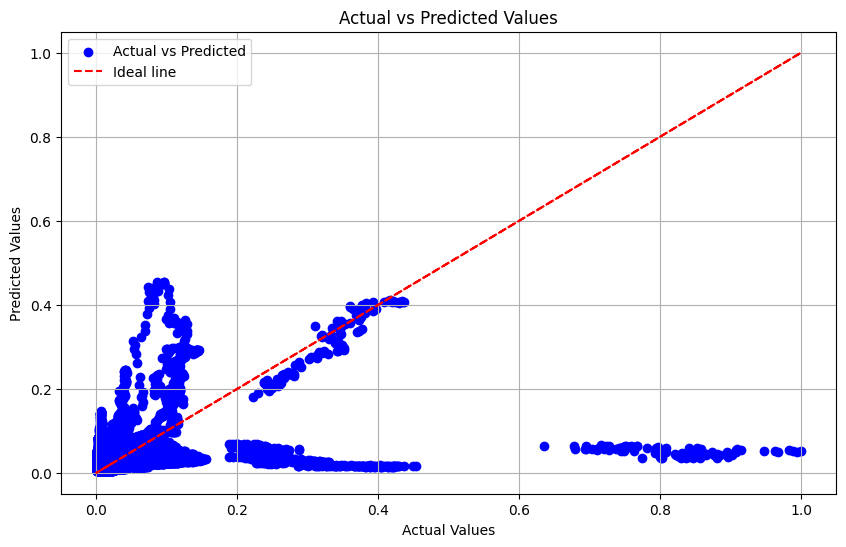

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# all_preds = np.array(all_preds)
# all_y = np.array(all_y)

plt.figure(figsize=(10, 6))
plt.scatter(all_y, all_preds, color='blue', label='Actual vs Predicted')
plt.plot(all_y, all_y, color='red', linestyle='--', label='Ideal line')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


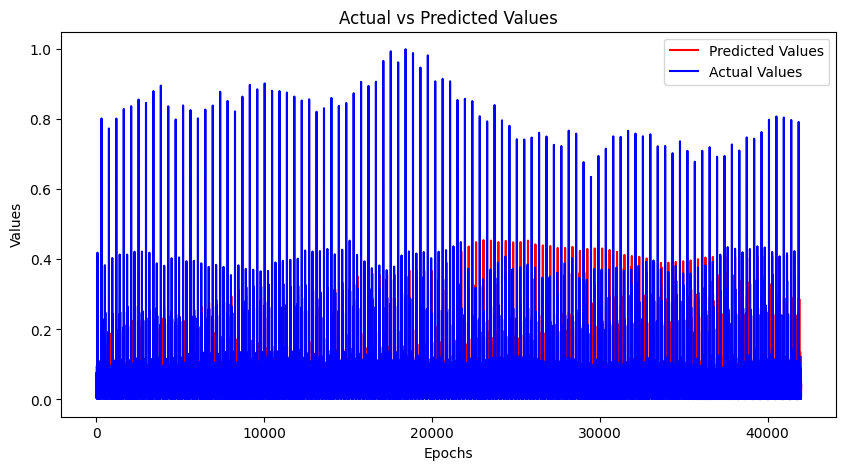

In [51]:
epochs = range(1, len(all_preds) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, all_preds, 'r-', label='Predicted Values')
plt.plot(epochs, all_y, 'b-', label='Actual Values')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()